In [3]:
using Distances
using DataStructures
#using TextModel
using SimilaritySearch
#using JSON
using PyCall
using PyPlot
#using Reactive, Interact, Compose
@pyimport sklearn.datasets as datagen
#include("../src/fft.jl")

In [4]:
function plot_clusters(data,labels,centers)
    pygui(false)
    PyPlot.hold(true)
    colors=["ro","bo","go","mo","co","yo",
        "r^","b^","g^","m^","c^","y^",
        "r*","b*","g*","m*","c*","y*"]
    ci=1
    for l in Set(labels)
        ind=[i for (i,v) in enumerate(labels) if v==l]
        plot(data[ind,1],data[ind,2], colors[ci])
        ci=ci+1
    end
    ax = axes()
#    for c in centers#(xp,yp) in zip(data[:,1],data[:,2])
 #       xp,yp=data[c,1],data[c,2]
 #       ax[:text](xp, yp, "$c", color="red", fontsize=14)
 #   end
  #  plot(data[centers,1],data[centers,2], "k8", markersize=10)
end

plot_clusters (generic function with 1 method)

In [13]:
function lassign(data,centers)
    labels=[]
    for i in 1:length(data[:,1]) 
        x=data[i,:]
        dist=sort([(evaluate(Euclidean(), x,data[c,:]),c) for c in centers])
        push!(labels,dist[1][2])
    end
    #println("llllllllllll ",labels, "      ", centers)
    return labels
end

lassign (generic function with 1 method)

In [14]:
function ffte(data,k::Int64)
    n=length(data[:,1])
    dst=KnnResult(n)
    c=rand(1:n)
    centers=[c]
    [push!(dst,i,Inf) for i in 1:n if i!=c]
    dd=[]
    while length(centers)<k
        dstn=KnnResult(n)
        c=last(centers)
        for nn in dst
            d=evaluate(Euclidean(), data[c,:],data[nn.objID,:])
            d = d<nn.dist ? d : nn.dist
            push!(dstn,nn.objID,d)
        end
        fn=pop!(dstn)
        dst=dstn
        push!(centers,fn.objID)
        push!(dd,fn.dist)
    end
    labels= lassign(data,centers)
    return centers, labels, dd               
end

ffte (generic function with 1 method)

In [8]:
function fftp(data,k::Int64)
    n=length(data[:,1])
    c=rand(1:n)
    centers=[c]
    partitions=[c for i in 1:n]
    dd=[]
    gg=[]
    while length(centers)<k
        res=[]
        for c in centers
            ind=[(i,l) for (i,l) in enumerate(partitions) if l==c]
            dist=sort([(evaluate(Euclidean(), data[c,:],data[i,:]),i,c) for (i,x) in ind])
            #println(":::::::::::::::: ",dist)
            push!(res,last(dist))
        end
        sort!(res)
        r=last(res)
        push!(centers,r[2])
        push!(dd,r[1])
        push!(gg,r[3])
        partitions = lassign(data,centers)
    end
    return centers,partitions,dd,gg              
end                                              

fftp (generic function with 1 method)

In [5]:
r,y=datagen.make_blobs(n_samples=20,centers=5);

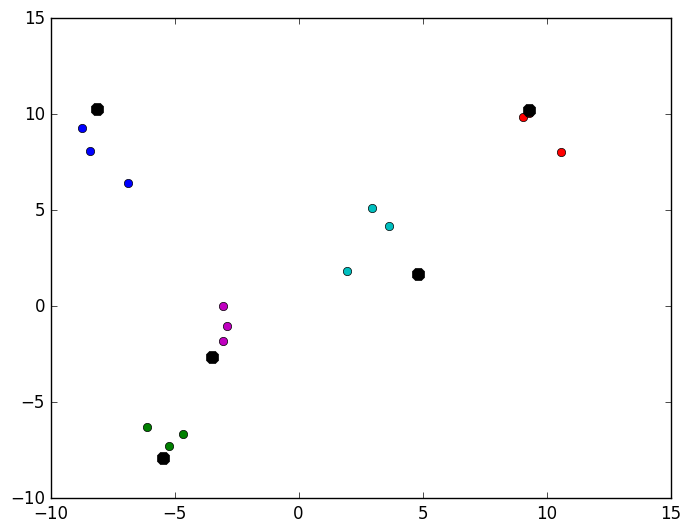

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12cd97438>

In [45]:
centros,lb,dd=ffte(r,5);
plot_clusters(r, lb, centros)

50-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [65]:
centros,gg,lb

([2, 1, 5, 3, 4], Any[2, 1, 5, 2], Any[1, 2, 3, 4, 5])

In [152]:
r1,y1 = datagen.make_moons(n_samples=1000,noise=0.1)

([-1.01258 -0.00181751; 2.16416 0.233419; … ; 1.04217 -0.336058; 0.391495 0.916356], [0, 1, 0, 0, 0, 0, 0, 1, 1, 1  …  1, 1, 0, 0, 0, 1, 0, 0, 1, 0])

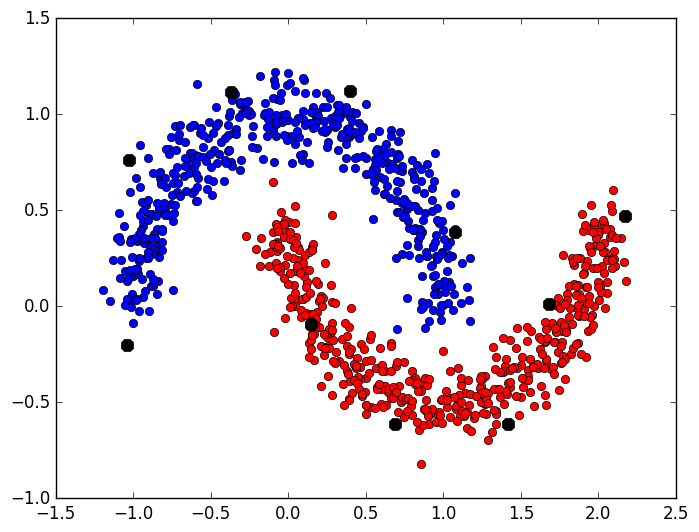

9-element Array{Any,1}:
 3.0574  
 1.81183 
 1.48708 
 0.983638
 0.923995
 0.898346
 0.846498
 0.834634
 0.550233

In [154]:
centros1,lb1,dd1=ffte(r1,10);
plot_clusters(r1,y1,centros1)
dd

In [365]:
include("../src/fft.jl")

fft (generic function with 2 methods)

In [18]:
using CPUTime

In [19]:
config=TextConfig(); config.nlist=[2]; config.qlist=[5];config.skiplist = []
tweets,vbows=list_of_items("../data/pionalisis.json","text",config);

In [20]:
@time @CPUtime c=fft(vbows,tweets,config,"text","3","maxmin");

>>>>>>>>>>>>>>> 53378 1.5707963267948966 29755
>>>>>>>>>>>>>>> 53377 1.5707963267948966 29754
>>>>>>>>>>>>>>> 53374 1.5707963267948966 29753
>>>>>>>>>>>>>>> 53371 1.5707963267948966 12953
>>>>>>>>>>>>>>> 53360 1.5707963267948966 12952
>>>>>>>>>>>>>>> 53359 1.5707963267948966 12951
>>>>>>>>>>>>>>> 53375 1.5707963267948966 10665
>>>>>>>>>>>>>>> 53336 1.5707963267948966 10664
>>>>>>>>>>>>>>> 53329 1.5707963267948966 10663
elapsed CPU time: 1.853175 seconds
  1.897334 seconds (2.02 M allocations: 95.822 MiB, 4.28% gc time)


In [30]:
@pyimport matplotlib.patches as patches
function animate_plot(data,centers,dd)
    pygui(true)
    PyPlot.ion()
    figure=PyPlot.figure()
    ax = axes()
    ax[:set_aspect]("equal")
    cc=["r","b","g","m","c","y"]
    colors=["ro","bo","go","mo","co","yo",
            "r^","b^","g^","m^","c^","y^",
            "r*","b*","g*","m*","c*","y*"]
    #min,max=minimum(data)-dd[1],maximum(data)+dd[1]
    min,max=-20,20
    for i = 1:length(centers)
        PyPlot.hold(true)
        ax[:cla]()
        ax[:set_ylim]([min,max])
        ax[:set_xlim]([min,max])
        #axis([0,2pi,-1,1])
        lcenters=centers[1:i]
        println("3333333",lcenters)
        labels=lassign(data,lcenters)
        ci=1
        for l in Set(labels)
            ind=[i for (i,v) in enumerate(labels) if v==l]
            ax[:plot](data[ind,1],data[ind,2], colors[ci])
            ci=ci+1
        end
        r = i>1 ? dd[i-1] : dd[1]
        for j in 1:i
            cc=lcenters[j]
            cir=patches.Circle(data[cc,:],r,
                                fc="blue",alpha=0.1,
                                linewidth=.5,zorder=0)
            ax[:add_artist](cir)
        end
        ax[:plot](data[lcenters,1],data[lcenters,2], "k8", markersize=10)
        #println(keys(ax))
        pause(0.1)
        PyPlot.draw()
        savefig("dreporte$i.png")
        PyPlot.hold(false)
    end
end

animate_plot (generic function with 1 method)

In [31]:
@pyimport matplotlib.patches as patches
function animate_path(data,centers,dd)
    pygui(true)
    PyPlot.ion()
    figure=PyPlot.figure()
    ax = axes()
    ax[:set_aspect]("equal")
    cc=["r","b","g","m","c","y"]
    colors=["ro","bo","go","mo","co","yo",
            "r^","b^","g^","m^","c^","y^",
            "r*","b*","g*","m*","c*","y*"]
    min,max=minimum(data)-1,maximum(data)+1
    min,max=-20,20
    for i = 1:length(centers)
        PyPlot.hold(true)
        ax[:cla]()
        ax[:set_ylim]([min,max])
        ax[:set_xlim]([min,max])
        lcenters=centers[1:i]
        labels=lassign(data,lcenters)
        ci=1
        for l in Set(labels)
            ind=[i for (i,v) in enumerate(labels) if v==l]
            ax[:plot](data[ind,1],data[ind,2], colors[ci])
            ci=ci+1
        end
        r = i>1 ? dd[i-1] : dd[1]
        for j in 1:i-1
            xi,yi=data[lcenters[j],:]
            xf,yf=data[lcenters[j+1],:]
            dx=xf-xi
            dy=yf-yi
            arr=patches.Arrow(xi,yi,dx,dy,zorder=1000,width=0.5)
            ax[:add_artist](arr)
        end
        ax[:plot](data[lcenters,1],data[lcenters,2], "k8", markersize=10)
        #println(keys(ax))
        pause(0.1)
        PyPlot.draw()
        savefig("rpath$i.png")
        PyPlot.hold(false)
    end
end

animate_path (generic function with 1 method)

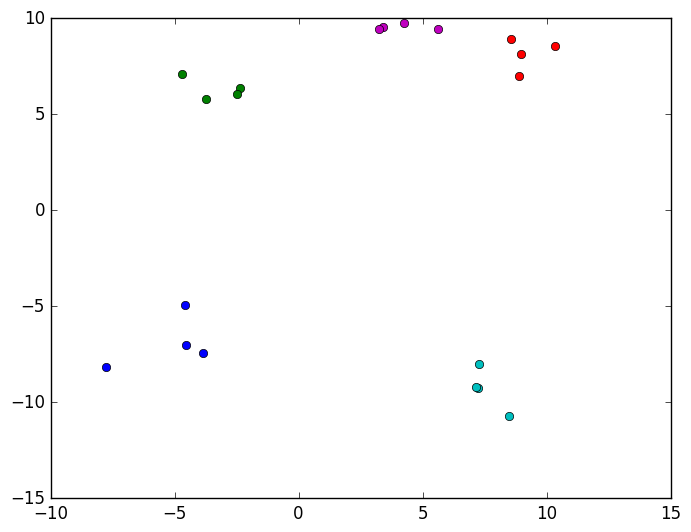

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1359df1d0>

In [27]:
r,y=datagen.make_blobs(n_samples=20,centers=5);
centros,lb,dd=ffte(r,5);
plot_clusters(r, y, centros)


In [32]:
animate_plot(r,centros,dd)

3333333[18]
3333333[18, 16]
3333333[18, 16, 13]
3333333[18, 16, 13, 9]
3333333[18, 16, 13, 9, 10]


In [33]:
animate_path(r,centros,dd)

In [68]:
centros

5-element Array{Int64,1}:
 2
 1
 5
 3
 4

In [169]:
println("El valor de x es $xx")

El valor de x es 1


In [28]:
@pyimport matplotlib.patches as patches
function animate_partition(data,centers,dd,gg)
    pygui(true)
    PyPlot.ion()
    figure=PyPlot.figure()
    ax = axes()
    cc=["r","b","g","m","c","y"]
    colors=["ro","bo","go","mo","co","yo",
            "r^","b^","g^","m^","c^","y^",
            "r*","b*","g*","m*","c*","y*"]
    min,max=minimum(data)-dd[1],maximum(data)+dd[1]
    ax[:set_aspect]("equal")
    for i = 1:length(centers)
        PyPlot.hold(true)
        ax[:cla]()
        ax[:set_ylim]([min,max])
        ax[:set_xlim]([min,max])
        #axis([0,2pi,-1,1])
        lcenters=centers[1:i]
        labels=lassign(data,lcenters)
        ci=1
        for l in Set(labels)
            ind=[i for (i,v) in enumerate(labels) if v==l]
            ax[:plot](data[ind,1],data[ind,2], colors[ci])
            ci=ci+1
        end
        counter=1
        #for (xp,yp) in zip(data[:,1],data[:,2])
        #      ax[:text](xp, yp, "$counter", color="red", fontsize=14)
         #     counter=counter+1
        #end
        #r = i>1 ? dd[i-1] : dd[1]
        for j in 1:i
            if j>1
                cc=gg[j-1]
                cd=centros[j]
                rr=evaluate(Euclidean(), data[cc,:], data[cd,:] )
                cir=patches.Circle(data[cc,:], rr,
                            fc="blue",alpha=0.1,
                            linewidth=.5,zorder=0)
                ax[:add_artist](cir)
            end
        end
        ax[:plot](data[lcenters,1],data[lcenters,2], "k8", markersize=10)
        #println(keys(ax))
        pause(1)
        PyPlot.draw()
        prefijo = i<10 ? "0$i": "$i"
        savefig("partitionbuena$prefijo.png")
        PyPlot.hold(false)
    end
end

animate_partition (generic function with 1 method)

In [29]:
animate_partition(r,centros,dd,gg)

In [14]:
gg

4-element Array{Any,1}:
 15
 15
 15
 18

In [75]:
centros

5-element Array{Int64,1}:
 2
 1
 5
 3
 4

4.870011465499301

In [389]:
[evaluate(Euclidean(),r[9], r[i]) for i in 1:length(r[:,1])]

20-element Array{Float64,1}:
  4.70753 
  0.718316
  4.19466 
  5.04997 
  0.319627
  1.97387 
  3.64747 
  3.17424 
  0.0     
  2.07293 
 11.1747  
  4.87001 
  9.75895 
  6.5981  
  9.15524 
  6.40269 
  7.73884 
  5.0755  
  7.71587 
  7.38455 

In [320]:
dd

4-element Array{Any,1}:
 17.4978 
 14.8089 
  7.68602
  4.0468 

In [422]:
gg,dd,centros

(Any[2, 2, 6, 2], Any[14.7662, 5.94798, 4.73666, 3.3654], [2, 15, 6, 3, 14])

In [423]:
lb

20-element Array{Any,1}:
  2
  2
  3
  6
 15
  6
 14
  6
  6
 15
 15
  3
  2
 14
 15
  3
  2
  2
  3
 14

In [47]:
r

5×2 Array{Float64,2}:
  4.34168    3.31327
  0.886109   3.81546
  4.70611   -6.84131
  3.48829    2.20299
 -4.39752   -7.25579

In [35]:
gg

4-element Array{Any,1}:
  2
  8
  2
 21

In [60]:
evaluate(Euclidean(), r[5,:], r[3,:])

9.113057898336868

In [61]:
dd

4-element Array{Any,1}:
 9.10363 
 3.82    
 3.45557 
 0.853395

In [77]:
r

5×2 Array{Float64,2}:
  2.83566    2.62948
 -1.77122    7.57811
  0.866751  -6.26713
 -1.11452    6.71172
 -2.57071   -3.17042

In [92]:
function pdist(data)
    n=length(r[:,1])
    D=zeros(n,n)
    for i in 1:n
        for j in i:n
            dij=evaluate(Euclidean(),data[i,:],data[j,:])
            #println("$i,$j ", dij)
            D[i,j]=dij
            D[j,i]= dij
        end
    end
    return D
end

pdist (generic function with 1 method)

In [267]:
function fftc(data, k)
    n=length(data[:,1])
    c=rand(1:n)
    c=1
    centers=[c]
    D=pdist(data)
    dd=[]
    while length(centers)<k
        #media=mean([data[c,:] for c in centers])
        dist=mean([D[i,:] for i in centers])
        #println(argsort)
        #println(dist)
        #dist=[evaluate(Euclidean(), data[j,:], media) for j in 1:length(data[:,1])]
        #println(dist)
        argsort=sortperm(dist, rev=true)
        for i in argsort
            if !(i in centers)
                push!(centers,i)
                push!(dd,dist[i])
                break
            end
        end
    end
    labels= lassign(data,centers)
    return centers,labels,dd
end

fftc (generic function with 1 method)

In [252]:
DD[10,:]

25-element Array{Float64,1}:
  3.04801
  6.56298
  5.5239 
  6.25852
  5.58879
  5.81214
  6.9166 
  4.78112
  9.56942
  0.0    
  6.31132
  5.36959
  2.37433
  4.12182
  8.02813
 11.7595 
 10.6302 
  6.58931
  9.98656
  6.85609
  6.65492
  2.15751
  7.34877
  5.62467
 10.5723 

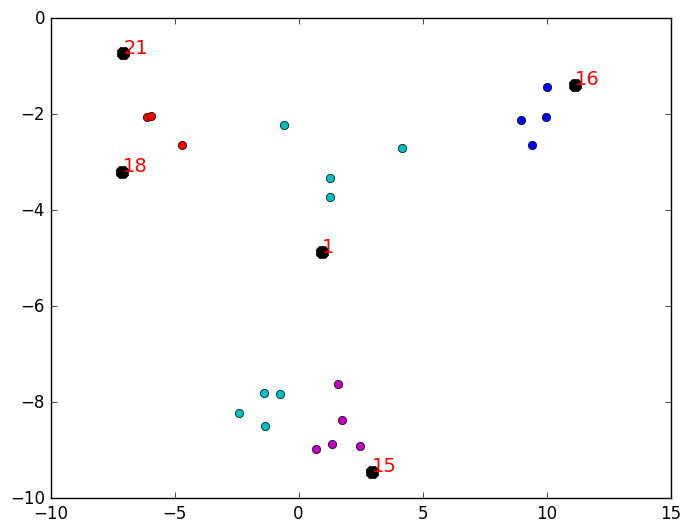

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x149cee470>

In [269]:
centrosc,lbc,ddc=fftc(r,5)
plot_clusters(r,lbc,centrosc)

In [255]:
centrosc

5-element Array{Int64,1}:
 23
 21
 16
 18
 17

In [256]:
mean([DD[i,:] for i in [23,21,16,18]])

25-element Array{Float64,1}:
  8.08467
  8.63225
  7.85113
  8.95078
  8.57066
  8.4492 
  8.83987
  9.0582 
 10.9831 
  8.08811
  8.92182
  7.83446
  8.18054
  7.73321
  9.32758
 12.0125 
 11.5169 
  7.99036
 11.1446 
  8.92623
  8.31753
  8.22181
  8.80246
  8.62523
 11.4369 